In [94]:
from collections import defaultdict, Counter
from functional import seq, pseq
import nltk
import numpy as np
import pandas as pd
import json
from os import path, makedirs

In [105]:
from plotnine import (
    ggplot, aes, facet_grid, facet_wrap,
    geom_histogram, geom_density, geom_segment, geom_text, geom_bar, geom_violin, geom_boxplot, geom_step, geom_vline,
    xlab, ylab, ggtitle,
    scale_color_manual, scale_fill_manual, scale_fill_discrete, scale_y_continuous, scale_color_discrete,
    coord_flip, theme,
    stat_ecdf, stat_ydensity, element_text
)
COLORS = [
    '#49afcd', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

output_path = 'output/plots/'
makedirs(output_path, exist_ok=True)

In [66]:
def format_question(q):
    q['n_sentences'] = len(q['tokenizations'])
    if q['subcategory'] == 'None':
        q['subcategory'] = None
    q['sentences'] = [q['text'][start:end] for start, end in q['tokenizations']]
    return q

In [67]:
with open('data/external/datasets/qanta.mapped.2018.04.18.json') as f:
    questions = [format_question(q) for q in json.load(f)['questions'] if q['fold'] != 'test']

In [9]:
with open('data/external/wikidata-claims_instance-of.jsonl') as f:
    claims = [json.loads(l) for l in f]

In [10]:
properties = defaultdict(set)
country_synonyms = {
    'former country',
    'member state of the United Nations',
    'sovereign state',
    'member state of the European Union',
    'permanent member of the United Nations Security Council',
    'member state of the Council of Europe'
}

for r in claims:
    title = r['title']
    if title is None:
        continue
    else:
        title = title.replace(' ', '_')
        obj = r['object']
        if r['property'] == 'instance of' and obj is not None:
            if 'Wikimedia' in obj:
                continue
            if obj in country_synonyms:
                properties[title].add('country')
            else:
                properties[title].add(obj)

object_properties = Counter()
for r in claims:
    if r['title'] is not None and r['object'] is not None and 'Wikimedia' not in r['object']:
        object_properties[r['object']] += 1

In [11]:
object_properties.most_common(n=20)

[('human', 1455334),
 ('taxon', 328538),
 ('film', 109797),
 ('album', 107465),
 ('human settlement', 106938),
 ('village', 96498),
 ('business enterprise', 56399),
 ('village of Poland', 51781),
 ('book', 47870),
 ('single', 46438),
 ('commune of France', 36828),
 ('train station', 36249),
 ('river', 35713),
 ('band', 35641),
 ('sports season', 30738),
 ('unincorporated community', 29786),
 ('television series', 28760),
 ('family name', 27799),
 ('song', 23941),
 ('mountain', 23166)]

In [12]:
def compute_question_property_counts(answers):
    question_property_counts = Counter()
    for page in answers:
        if page in properties:
            q_props = properties[page]
            if 'human' in q_props:
                if len(q_props) == 1:
                    question_property_counts['human'] += 1
                    continue
                elif 'human biblical character' in q_props:
                    question_property_counts['human biblical character'] += 1
                    continue
                elif 'Catholic saint' in q_props:
                    question_property_counts['Catholic saint'] += 1
            for prop in q_props:
                question_property_counts[prop] += 1
    return question_property_counts

In [13]:
qb_question_property_counts = compute_question_property_counts([q['page'] for q in questions])
qb_question_property_counts.most_common(n=20)

[('human', 32890),
 ('book', 7544),
 ('country', 4917),
 ('play', 1945),
 ('city', 1438),
 ('literary work', 1360),
 ('battle', 1138),
 ('chemical compound', 1114),
 ('taxon', 1113),
 ('painting', 1103),
 ('poem', 951),
 ('opera', 785),
 ('mythological Greek character', 752),
 ('war', 745),
 ('chemical element', 693),
 ('film', 681),
 ('capital', 677),
 ('fictional human', 674),
 ('island nation', 650),
 ('state of the United States', 604)]

In [14]:
def compute_answer_type_assignments(question_property_counts, answers):
    answer_type_assignments = {}
    for page in answers:
        if page in properties:
            q_props = list(properties[page])
            if len(q_props) == 1:
                answer_type_assignments[page] = q_props[0]
            else:
                prop_counts = [question_property_counts[prop] for prop in q_props]
                props_with_counts = zip(prop_counts, q_props)
                _, most_common_prop = max(props_with_counts)
                answer_type_assignments[page] = most_common_prop
        else:
            answer_type_assignments[page] = 'NOMATCH'
    return answer_type_assignments

In [15]:
qb_answer_type_assignments = compute_answer_type_assignments(qb_question_property_counts, [q['page'] for q in questions])

In [69]:
for i in range(len(questions)):
    q = questions[i]
    q['instance of'] = qb_answer_type_assignments[q['page']]

In [70]:
df = pd.DataFrame(questions)

In [47]:
df.n_sentences.sum()

695063

In [22]:
len(df.page.unique())

29398

/home/entilzha/.local/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/entilzha/.local/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: output/plots/n_sentence_histogram.pdf
  warn('Filename: {}'.format(filename))


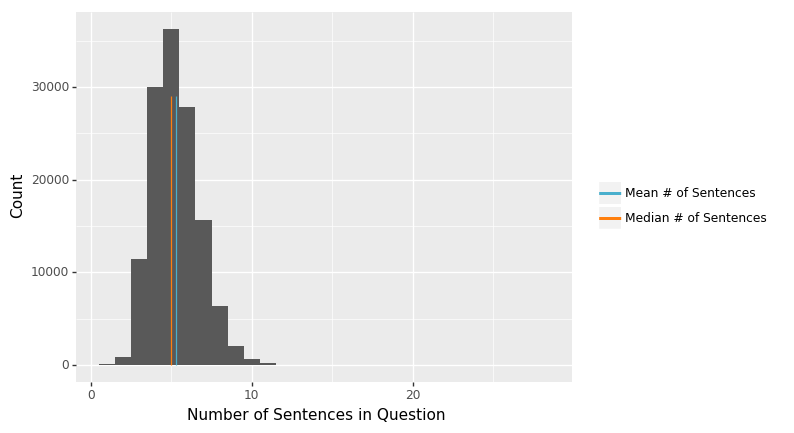

<ggplot: (8756792715966)>

In [96]:
mean_len = df.n_sentences.mean()
median_len = df.n_sentences.median()
stats_df = pd.DataFrame([
    {'n': mean_len, ' ': 'Mean # of Sentences'},
    {'n': median_len, ' ': 'Median # of Sentences'}
])
p = (
    ggplot(df)
    + aes(x='n_sentences')
    + geom_histogram(binwidth=1)
    + geom_segment(
        aes(x='n', xend='n', y=0, yend=29000, color=' '),
        stats_df
    )
    + xlab('Number of Sentences in Question')
    + ylab('Count')
    + scale_color_manual(values=COLORS)
)
#p.save(path.join(output_path, 'n_sentence_histogram.pdf'))
p

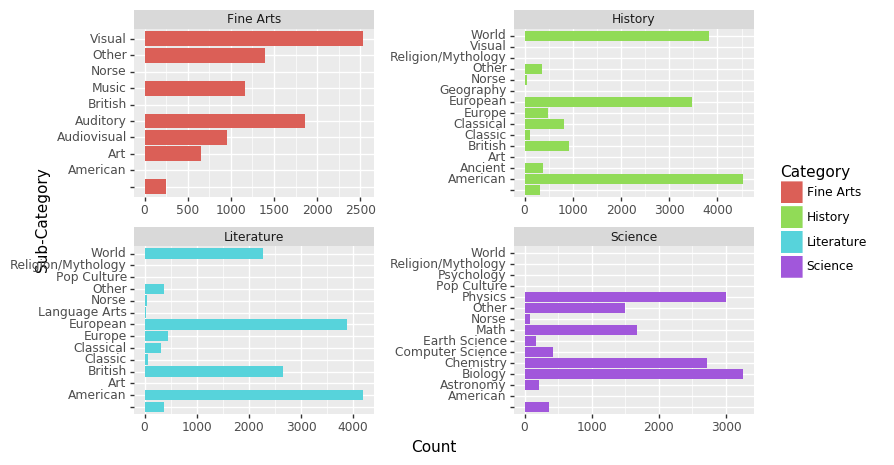

<ggplot: (8756481333277)>

In [119]:
# TODO:
# - Fix Sub-category on top of panel labels
# - Fix ordering by count
# - Fix filtering out low counts

plot_df = df.dropna(subset=['subcategory'])
top_categories = {'Science', 'Literature', 'History', 'Fine Arts'}
plot_df = plot_df[plot_df.category.isin(top_categories)]
p = (
    ggplot(plot_df)
    + facet_wrap('category', scales='free')
    + aes(x='subcategory', fill='category')
    + geom_bar()
    + xlab('Sub-Category') + ylab('Count') + coord_flip()
    + theme(panel_spacing_x=1.4, panel_spacing_y=.3, figure_size=(8, 5))
    + scale_fill_discrete(name="Category")
)
#p.save(path.join(output_path, 'subcategories.pdf'))
p

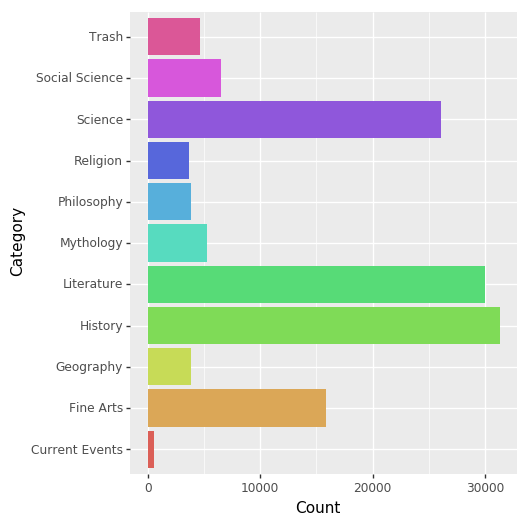

<ggplot: (-9223363280050250829)>

In [28]:
p = (
    ggplot(df)
    + aes(x='category', fill='category')
    + geom_bar(show_legend=False)
    + xlab('Category') + ylab('Count') + coord_flip()
    + theme(figure_size=(5, 6))
)
#p.save(path.join(output_path, 'categories.pdf'))
p

In [52]:
with open('data/external/squad/train-v1.1.json') as f:
    squad_dataset = json.load(f)['data']
squad_questions = []
squad_titles = set()
for page in squad_dataset:
    squad_titles.add(page['title'])
    for cqa in page['paragraphs']:
        for qa in cqa['qas']:
            squad_questions.append(qa['question'])

In [53]:
len(squad_questions)

87599

In [54]:
outlier_percentile = .95

In [55]:
# SQuAD Question Lengths
squad_word_dist = pseq(squad_questions).map(lambda s: len(nltk.word_tokenize(s))).list()
squad_word_dist = np.array(squad_word_dist)
squad_word_df = pd.DataFrame({'n': squad_word_dist})
squad_word_df['source'] = '# Words in Question'
squad_word_df['dataset'] = 'SQuAD'
squad_quantile = squad_word_df['n'].quantile(outlier_percentile)
squad_word_df = squad_word_df[squad_word_df.n <= squad_quantile]

In [56]:
# TriviaQA Question Lengths
with open('data/external/triviaqa/unfiltered-web-train.json') as f:
    tqa_data = json.load(f)['Data']
tqa_questions = []
tqa_answers = []
for q in tqa_data:
    if q['Answer']['Type'] == 'WikipediaEntity':
        tqa_questions.append(q['Question'])
        tqa_answers.append(q['Answer']['MatchedWikiEntityName'].replace(' ', '_'))

In [57]:
print(len(tqa_questions))

74616


In [58]:
tqa_word_dist = pseq(tqa_questions).map(lambda s: len(nltk.word_tokenize(s))).list()
tqa_word_dist = np.array(tqa_word_dist)
tqa_word_df = pd.DataFrame({'n': tqa_word_dist})
tqa_word_df['source'] = '# Words in Question'
tqa_word_df['dataset'] = 'TriviaQA'
tqa_quantile = tqa_word_df['n'].quantile(outlier_percentile)
tqa_word_df = tqa_word_df[tqa_word_df.n <= tqa_quantile]

In [59]:
tqa_question_property_counts = compute_question_property_counts(tqa_answers)
tqa_question_property_counts.most_common(n=20)

[('human', 17040),
 ('country', 4868),
 ('city', 2508),
 ('taxon', 2419),
 ('book', 1001),
 ('capital', 933),
 ('film', 869),
 ('television series', 843),
 ('state of the United States', 806),
 ('business enterprise', 793),
 ('city with millions of inhabitants', 761),
 ('island nation', 752),
 ('big city', 748),
 ('band', 661),
 ('landlocked country', 590),
 ('fictional human', 578),
 ('chemical element', 551),
 ('republic', 520),
 ('common name', 520),
 ('town', 510)]

In [60]:
tqa_answer_type_assignments = compute_answer_type_assignments(tqa_question_property_counts, tqa_answers)

In [62]:
# SimpleQuestions QuestionLengths
with open('data/external/simplequestions/annotated_fb_data_train.txt') as f:
    sq_questions = []
    sq_answers = []
    for line in f:
        splits = line.split('\t')
        sq_questions.append(splits[3].strip())
        sq_answers.append(splits[2].strip())

In [63]:
sq_word_dist = pseq(sq_questions).map(lambda s: len(nltk.word_tokenize(s))).list()
sq_word_dist = np.array(sq_word_dist)
sq_word_df = pd.DataFrame({'n': sq_word_dist})
sq_word_df['source'] = '# Words in Question'
sq_word_df['dataset'] = 'SimpleQuestions'
sq_quantile = sq_word_df['n'].quantile(outlier_percentile)
sq_word_df = sq_word_df[sq_word_df.n <= sq_quantile]

In [64]:
# jeopardy
with open('data/external/jeopardy/jeopardy_questions.json') as f:
    j_questions = []
    j_answers = []
    j_data = json.load(f)
    for q in j_data:
        j_questions.append(q['question'])
        j_answers.append(q['answer'])

In [65]:
j_word_dist = pseq(j_questions).map(lambda s: len(nltk.word_tokenize(s))).list()
j_word_dist = np.array(j_word_dist)
j_word_df = pd.DataFrame({'n': j_word_dist})
j_word_df['source'] = '# Words in Question'
j_word_df['dataset'] = 'Jeopardy!'
j_quantile = j_word_df['n'].quantile(outlier_percentile)
j_word_df = j_word_df[j_word_df.n <= j_quantile]

In [71]:
# Quiz Bowl Question Lengths
sent_word_dist = pseq(questions).flat_map(lambda q: q['sentences']).map(lambda s: len(nltk.word_tokenize(s))).list()
question_word_dist = pseq(questions).map(lambda q: q['text']).map(lambda s: len(nltk.word_tokenize(s))).list()
sent_word_dist = np.array(sent_word_dist)
question_word_dist = np.array(question_word_dist)
sent_word_df = pd.DataFrame({'n': sent_word_dist})
sent_word_df['source'] = '# Words in Question'
sent_word_df['dataset'] = 'QB (sentence)'
sent_quantile = sent_word_df['n'].quantile(outlier_percentile)
sent_word_df = sent_word_df[sent_word_df.n <= sent_quantile]

question_word_df = pd.DataFrame({'n': question_word_dist})
question_word_df['source'] = '# Words in Question'
question_word_df['dataset'] = 'QB (question)'
question_quantile = question_word_df['n'].quantile(outlier_percentile)
question_word_df = question_word_df[question_word_df.n <= question_quantile]

quiz_bowl_word_df = pd.concat([sent_word_df, question_word_df])

In [72]:
word_df = pd.concat([quiz_bowl_word_df, squad_word_df, tqa_word_df, sq_word_df, j_word_df])

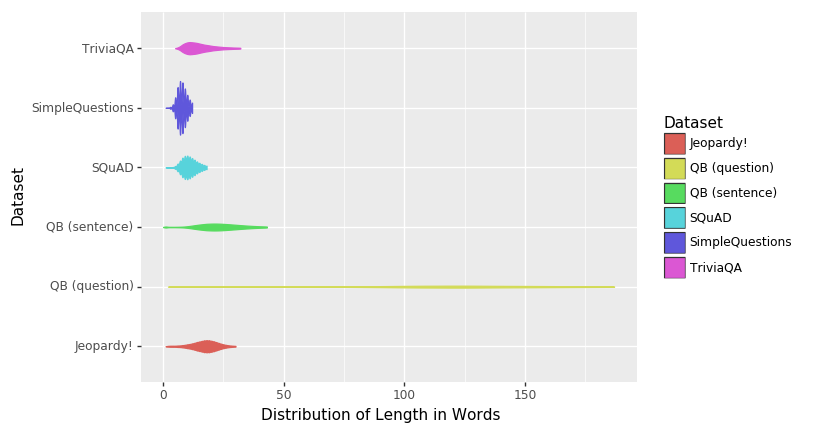

<ggplot: (8756497238469)>

In [73]:
p = (
    ggplot(word_df) + aes(x='dataset', y='n')
    + geom_violin(aes(fill='dataset', color='dataset'), trim=True, show_legend={'color': False})# + geom_boxplot(outlier_shape=None, outlier_alpha=0, width=.1)
    + xlab('Dataset') + ylab('Distribution of Length in Words') + coord_flip()
    + scale_fill_discrete(name='Dataset')
)
#p.save(path.join(output_path, 'length_dist.pdf'))
p

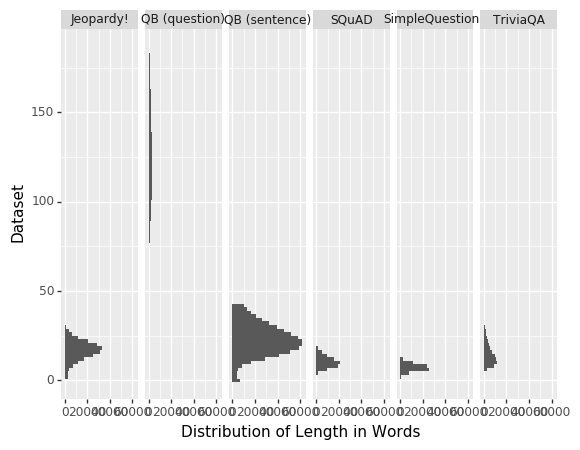

<ggplot: (8756497246654)>

In [74]:
(
    ggplot(word_df) + facet_wrap('dataset', nrow=1) + aes(x='n')
    + geom_histogram(binwidth=2)
    + xlab('Dataset') + ylab('Distribution of Length in Words') + coord_flip()
)

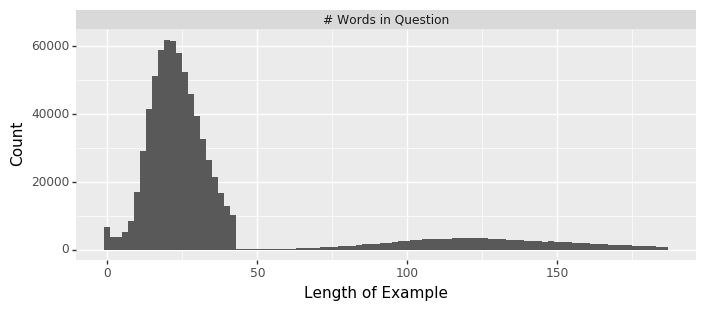

<ggplot: (-9223363280350271151)>

In [75]:
(
    ggplot() + aes(x='n') + facet_wrap('source', scales='free')
    + geom_histogram(data=sent_word_df, binwidth=2)
    + geom_histogram(data=question_word_df, binwidth=2)
    + theme(panel_spacing_x=.5, figure_size=(8, 3))
    + xlab('Length of Example') + ylab('Count')
)

In [82]:
qb_type_df = df.groupby(['instance of', 'category']).count().reset_index()
qb_type_df['n'] = qb_type_df['qanta_id'] #  This is a dummie column for counts
qb_type_df['dataset'] = 'Quiz Bowl'
#qb_type_df = qb_type_df[qb_type_df['instance of'] != 'NOMATCH']
qb_type_df = qb_type_df.sort_values('n', ascending=False)[['instance of', 'category', 'n', 'dataset']][:30]

In [83]:
tqa_counts = Counter(tqa_answer_type_assignments.values())
tqa_type_df = pd.DataFrame(tqa_counts.most_common(30), columns=['instance of', 'n'])
tqa_type_df['category'] = 'NA'
tqa_type_df['dataset'] = 'TriviaQA'
#tqa_type_df = tqa_type_df[tqa_type_df['instance of'] != 'NOMATCH']

In [84]:
#type_df = pd.concat([qb_type_df, tqa_type_df])
type_df = qb_type_df

ordered_categories = list(type_df.groupby('instance of').sum().reset_index().sort_values('n', ascending=False)['instance of'])
type_df['instance of'] = pd.Categorical(type_df['instance of'], categories=ordered_categories, ordered=True)

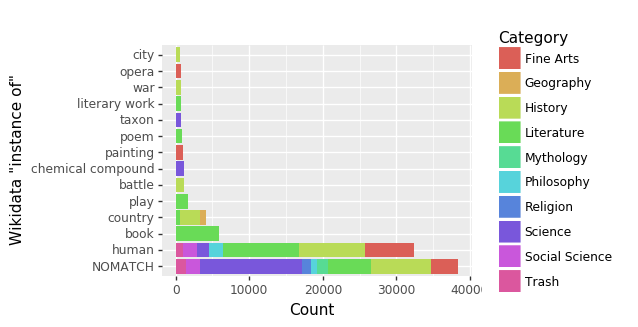

<ggplot: (-9223363280062439413)>

In [85]:
p = (
    ggplot(type_df) + aes(x='instance of', y='n', fill='category')
    + geom_bar(stat='identity') + coord_flip()
    + xlab('Wikidata "instance of"') + ylab('Count')
    + scale_fill_discrete(name="Category") + theme(figure_size=(4, 3))
)
#p.save(path.join(output_path, 'ans_type_dist.pdf'))
p

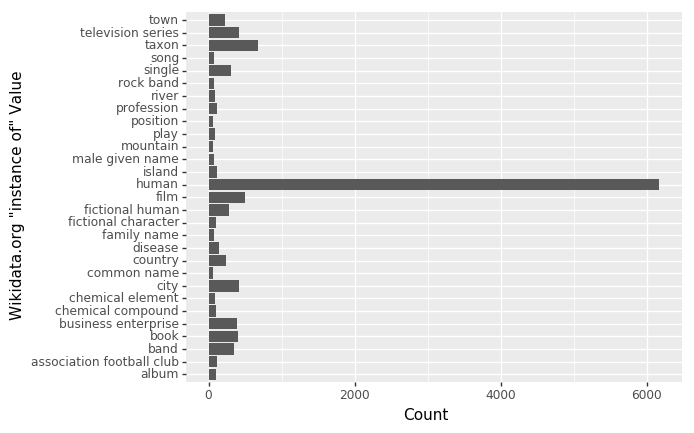

<ggplot: (-9223363280062399442)>

In [87]:
p = (
    ggplot(tqa_type_df[tqa_type_df['instance of'] != 'NOMATCH']) + aes(x='instance of', y='n')
    + geom_bar(stat='identity') + coord_flip()
    + xlab('Wikidata.org "instance of" Value') + ylab('Count')
)
#p.save(path.join(output_path, 'ans_type_dist.pdf'))
p

In [88]:
qb_answers = list(df.page.values)

In [89]:
qb_a_counts = Counter(qb_answers)
j_a_counts = Counter(j_answers)
tqa_a_counts = Counter(tqa_answers)
sq_a_counts = Counter(sq_answers)

In [90]:
def create_answer_count_df(counts, name):
    rows = []
    for n in counts.values():
        rows.append({'n': n, 'dataset': name})
    ac_df = pd.DataFrame(rows)
    total = ac_df.n.sum()
    ac_df['p'] = ac_df.n / total
    ac_df = ac_df.sort_values('n', ascending=False)
    ac_df['cdf'] = ac_df.p.cumsum()
    ac_df['x'] = list(range(1, len(ac_df) + 1))
    ac_df['r'] = ac_df['x'] / (len(ac_df) + 1)
    return ac_df

In [91]:
answer_count_df = pd.concat([
    create_answer_count_df(qb_a_counts, 'Quiz Bowl'),
    create_answer_count_df(j_a_counts, 'Jeopardy!'),
    create_answer_count_df(tqa_a_counts, 'TriviaQA'),
    create_answer_count_df(sq_a_counts, 'SimpleQuestions')
])

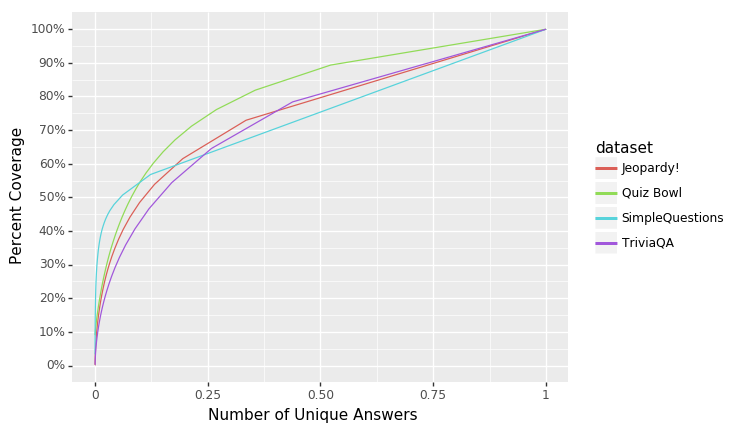

<ggplot: (8756792815908)>

In [93]:
def percent_scale(breakpoints):
    return [f'{100 * b:.0f}%' for b in breakpoints]

p = (
    ggplot(answer_count_df) + aes(x='r', y='cdf', color='dataset')
    + geom_step()
    + xlab('Number of Unique Answers') + ylab('Percent Coverage')
    + scale_y_continuous(labels=percent_scale, breaks=np.linspace(0, 1, num=11))
)
#p.save(path.join(output_path, 'unique_answer_coverage.pdf'))
p